<a href="https://colab.research.google.com/github/gigihsantoso/prediksi-saham/blob/main/Deep_Learning_Saham_TLKM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 496 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


#Time Series

##Setup

In [2]:
import yfinance as yf
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive, files, data_table
import tensorflow as tf
from sklearn.metrics import confusion_matrix

## Load Data

In [3]:
data = yf.download('TLKM.JK', period='max').astype(int).sort_index(ascending=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
data = data.reset_index()
data['Date']= data['Date'].astype("string")

##Exploring

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4432 entries, 0 to 4431
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       4432 non-null   string
 1   Open       4432 non-null   int64 
 2   High       4432 non-null   int64 
 3   Low        4432 non-null   int64 
 4   Close      4432 non-null   int64 
 5   Adj Close  4432 non-null   int64 
 6   Volume     4432 non-null   int64 
dtypes: int64(6), string(1)
memory usage: 242.5 KB


In [6]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-09-28,835,835,825,825,485,90095000
1,2004-09-29,825,825,810,825,485,29370000
2,2004-09-30,825,830,825,830,488,42927500
3,2004-10-01,830,845,825,840,494,108387500
4,2004-10-04,845,880,845,870,511,424210000


In [7]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000,4.432000e+03
mean,2557.254287,2586.568141,2527.868908,2557.211191,2078.430505,1.002661e+08
std,1103.876133,1112.890363,1094.513002,1103.664290,1107.543908,6.404088e+07
min,820.000000,825.000000,810.000000,825.000000,485.000000,0.000000e+00
25%,1570.000000,1600.000000,1550.000000,1570.000000,1127.000000,6.055748e+07
50%,2250.000000,2275.000000,2210.000000,2250.000000,1724.000000,8.635625e+07
75%,3610.000000,3660.000000,3580.000000,3610.000000,3172.000000,1.229296e+08
max,4850.000000,4850.000000,4780.000000,4800.000000,4700.000000,8.080050e+08


##Helper

In [8]:
def dataframe_split(data, test= 7):
  part_  = data.iloc[:int(test * -1)]
  rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

In [9]:
def df_to_tsdf(data, input_width, label_width, batch_size):
    series = tf.expand_dims(data, axis=-1)
    fts = tf.data.Dataset.from_tensor_slices(series)
    window = fts.window(input_width+label_width, shift=label_width, drop_remainder=True)
    flat = window.flat_map(lambda w: w.batch(input_width+label_width))
    map = flat.map(lambda w: (w[:input_width * -1], w[label_width * -1:]))
    batch = map.batch(batch_size)
    ds = batch.prefetch(tf.data.AUTOTUNE)
    return ds

##Preprocessing

In [10]:
df_model = data.copy()
df_model['Scaler'] =  (df_model.loc[:, 'Close']-df_model.loc[:, 'Close'].min())/(df_model.loc[:, 'Close'].max()-df_model.loc[:, 'Close'].min())

In [11]:
train_m, test_m = dataframe_split(df_model, test=60)

In [12]:
data_m = train_m['Scaler']
input_width = 30
label_width = 30
batch_size = 128
ds = df_to_tsdf(data_m, input_width, label_width, batch_size)

##Model

In [13]:
#Buatlah model dengan input layer disarankan menggunakan LSTM LSTM dan output layer 1 
model = tf.keras.models.Sequential([
    #Code Here
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(30),
    # tf.keras.layers.Reshape([6, 1])
])
model.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(ds, epochs =10000)

Output streaming akan dipotong hingga 5000 baris terakhir.
2/2 [==============================] - 0s 36ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7502/10000
2/2 [==============================] - 0s 38ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7503/10000
2/2 [==============================] - 0s 37ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7504/10000
2/2 [==============================] - 0s 33ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7505/10000
2/2 [==============================] - 0s 30ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7506/10000
2/2 [==============================] - 0s 37ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7507/10000
2/2 [==============================] - 0s 42ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7508/10000
2/2 [==============================] - 0s 42ms/step - loss: 0.0017 - mean_absolute_error: 0.0301
Epoch 7509/10000
2/2 [========================

##Evaluate

In [14]:
input =tf.convert_to_tensor([test_m['Scaler'].iloc[:-30].to_numpy()])
predictions_m = model.predict(input)

1/1 [==============================] - 0s 474ms/step


In [15]:
data_predict = pd.DataFrame(data=test_m['Date'].iloc[-30:], columns=['Date'])
data_predict.insert(1, 'Predict', predictions_m.flatten())
data_predict.set_index('Date', inplace=True)
test_m.set_index('Date', inplace=True)

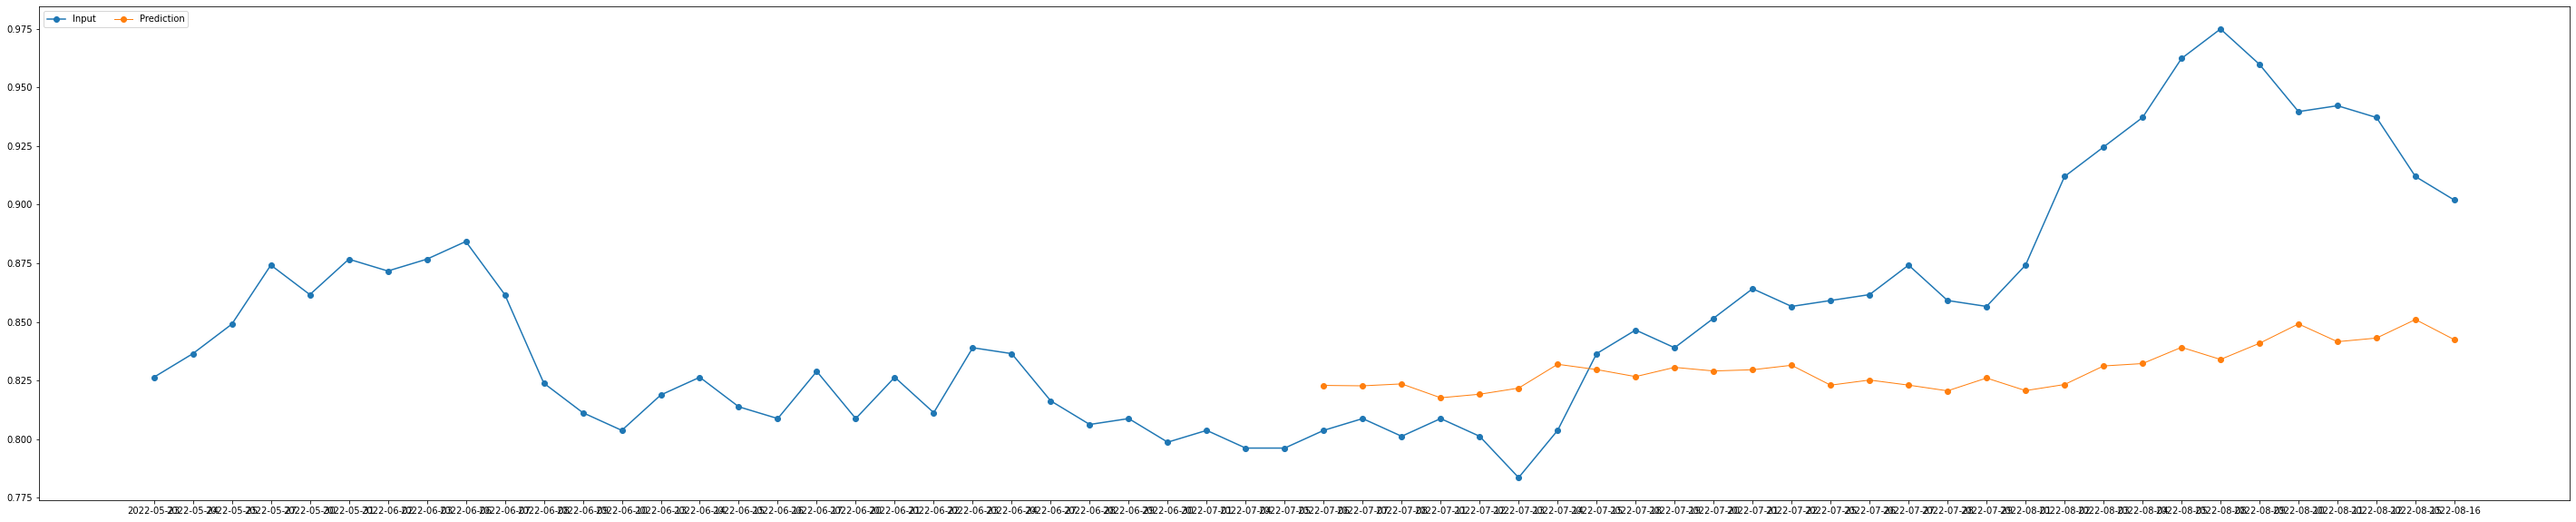

In [16]:
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(test_m['Scaler'], marker="o", linewidth=1.5)
ax.plot(data_predict, marker="o", linewidth=1)
ax.legend(["Input", 'Prediction'], loc='upper left', ncol=3, )
plt.show()

##Simulation

In [17]:
data_sim = data.copy()
data_sim['Scaler'] =  (data_sim.loc[:, 'Close']-data_sim.loc[:, 'Close'].min())/(data_sim.loc[:, 'Close'].max()-data_sim.loc[:, 'Close'].min())

In [18]:
input_sim =tf.convert_to_tensor([data_sim['Scaler'].iloc[-30:].to_numpy()])
predictions_sim = model.predict(input_sim)

1/1 [==============================] - 0s 22ms/step


In [19]:
a = pd.DataFrame(data_sim['Scaler'].iloc[-30:].to_numpy(), columns=['Data'])
b = pd.DataFrame(data=predictions_sim.flatten(), columns=['Data'])
sim = pd.concat([a, b], ignore_index=True)

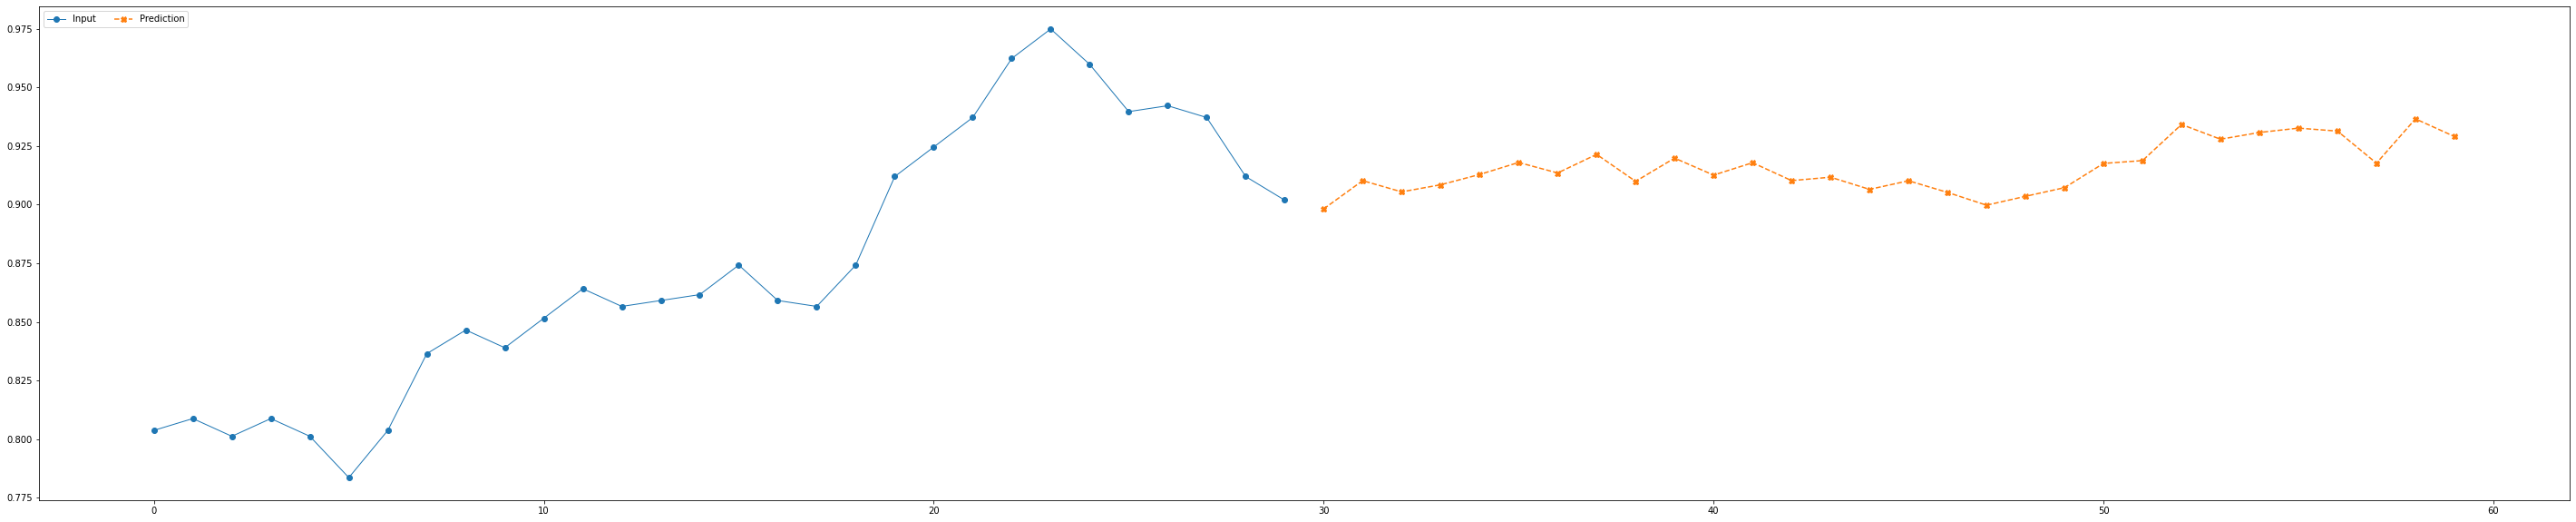

In [20]:
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(sim.iloc[:-30], marker="o", linewidth=1)
ax.plot(sim.iloc[-30:], marker="X", linewidth=1.5, ls="--")
ax.legend(["Input", 'Prediction'], loc='upper left', ncol=3, )
plt.show()

##Save Model

In [21]:
MODEL_DIR = "models/model"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
tf.keras.models.save_model(
    model,
    export_path
)

## Download Save Model

In [22]:
!zip -r /content/model_bris.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/model/ (stored 0%)
  adding: content/models/model/1/ (stored 0%)
  adding: content/models/model/1/saved_model.pb (deflated 90%)
  adding: content/models/model/1/keras_metadata.pb (deflated 88%)
  adding: content/models/model/1/assets/ (stored 0%)
  adding: content/models/model/1/variables/ (stored 0%)
  adding: content/models/model/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/model/1/variables/variables.index (deflated 52%)


In [23]:
files.download('/content/model_bris.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Check aja

In [24]:
data_test = data.copy()
data_test['Scaler'] =  (data_test.loc[:, 'Close']-data_test.loc[:, 'Close'].min())/(data_test.loc[:, 'Close'].max()-data_test.loc[:, 'Close'].min())

In [25]:
data_test.describe()

,Open,High,Low,Close,Adj Close,Volume,Scaler
count,4432.000000,4432.000000,4432.000000,4432.000000,4432.000000,4.432000e+03,4432.000000
mean,2557.254287,2586.568141,2527.868908,2557.211191,2078.430505,1.002661e+08,0.435776
std,1103.876133,1112.890363,1094.513002,1103.664290,1107.543908,6.404088e+07,0.277651
min,820.000000,825.000000,810.000000,825.000000,485.000000,0.000000e+00,0.000000
25%,1570.000000,1600.000000,1550.000000,1570.000000,1127.000000,6.055748e+07,0.187421
50%,2250.000000,2275.000000,2210.000000,2250.000000,1724.000000,8.635625e+07,0.358491
75%,3610.000000,3660.000000,3580.000000,3610.000000,3172.000000,1.229296e+08,0.700629
max,4850.000000,4850.000000,4780.000000,4800.000000,4700.000000,8.080050e+08,1.000000


In [26]:
input_tes =tf.convert_to_tensor([data_test['Scaler'].iloc[-290:-260].to_numpy()])
predictions_test = model.predict(input_tes)

1/1 [==============================] - 0s 19ms/step


In [27]:
input_tes_2 =tf.convert_to_tensor([data_test['Scaler'].iloc[-320:-290].to_numpy()])
predictions_test_2 = model.predict(input_tes_2)

1/1 [==============================] - 0s 18ms/step


In [28]:
input_tes_3 =tf.convert_to_tensor([data_test['Scaler'].iloc[-260:-230].to_numpy()])
predictions_test_3 = model.predict(input_tes_3)

1/1 [==============================] - 0s 19ms/step


In [29]:
data_predict_test = pd.DataFrame(data=data_test['Date'].iloc[-290:-260], columns=['Date'])
data_predict_test.insert(1, 'Predict', predictions_test.flatten())
data_predict_test.set_index('Date', inplace=True)

In [30]:
data_predict_test_2 = pd.DataFrame(data=data_test['Date'].iloc[-320:-290], columns=['Date'])
data_predict_test_2.insert(1, 'Predict', predictions_test_2.flatten())
data_predict_test_2.set_index('Date', inplace=True)

In [31]:
data_predict_test_3 = pd.DataFrame(data=data_test['Date'].iloc[-260:-230], columns=['Date'])
data_predict_test_3.insert(1, 'Predict', predictions_test_3.flatten())
data_predict_test_3.set_index('Date', inplace=True)
data_test.set_index('Date', inplace=True)

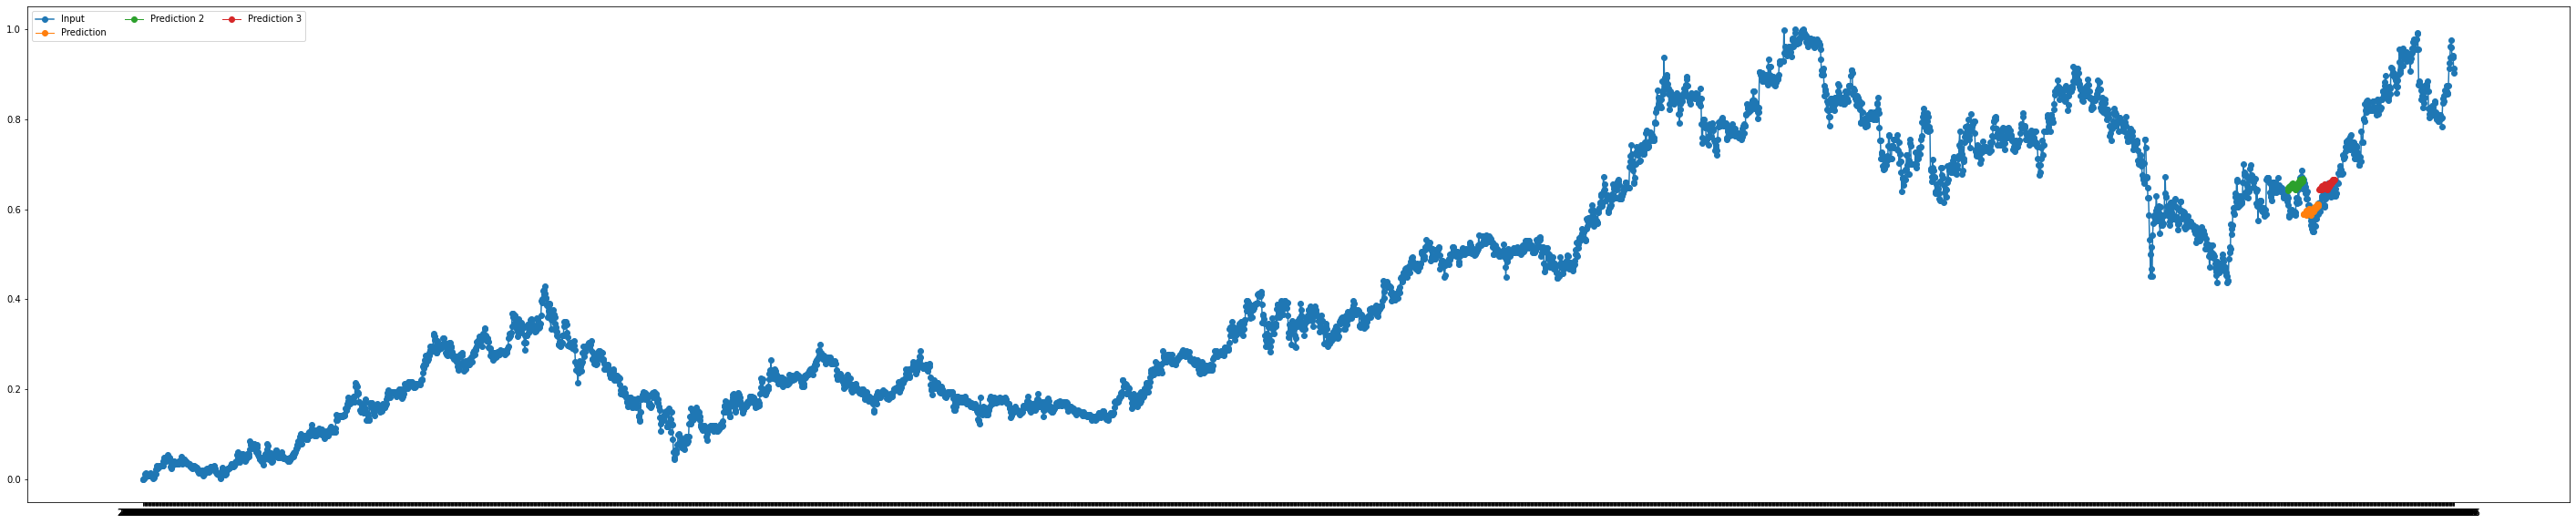

In [32]:
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(data_test['Scaler'], marker="o", linewidth=1.5)
ax.plot(data_predict_test, marker="o", linewidth=1)
ax.plot(data_predict_test_2, marker="o", linewidth=1)
ax.plot(data_predict_test_3, marker="o", linewidth=1)
ax.legend(["Input", 'Prediction', 'Prediction 2', 'Prediction 3'], loc='upper left', ncol=3, )
plt.show()